In [1]:
%load_ext cudf.pandas
import pandas as pd

### Usuarios

In [2]:
df_users = pd.read_csv('../data/lastfm/userid-profile.tsv', sep='\t')

In [3]:
df_users.head()

,#id,gender,age,country,registered
0,user_000001,m,<NA>,Japan,"Aug 13, 2006"
1,user_000002,f,<NA>,Peru,"Feb 24, 2006"
2,user_000003,m,22,United States,"Oct 30, 2005"
3,user_000004,f,<NA>,None,"Apr 26, 2006"
4,user_000005,m,<NA>,Bulgaria,"Jun 29, 2006"


In [4]:
df_users.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   #id         992 non-null    object
 1   gender      884 non-null    object
 2   age         286 non-null    int64
 3   country     907 non-null    object
 4   registered  984 non-null    object
dtypes: int64(1), object(4)
memory usage: 55.3+ KB


In [5]:
df_users_nage_nregistered = df_users.drop(columns=['age', 'registered'], axis=1)

In [6]:
df_users_nonull = df_users_nage_nregistered.dropna()

In [7]:
df_users_nonull.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 848 entries, 0 to 991
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   #id      848 non-null    object
 1   gender   848 non-null    object
 2   country  848 non-null    object
dtypes: object(3)
memory usage: 34.7+ KB


<Axes: xlabel='gender'>

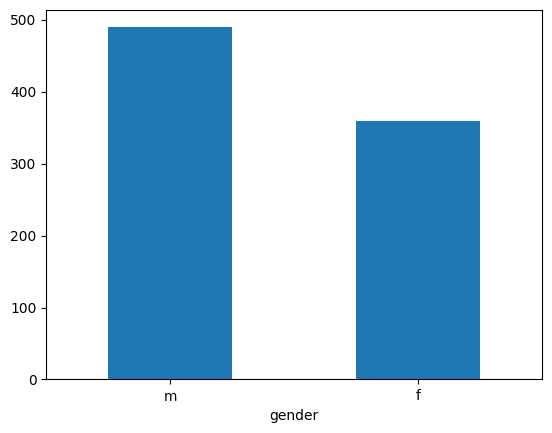

In [8]:
df_users_nonull.gender.value_counts().plot(kind='bar', rot=1)

<Axes: ylabel='country'>

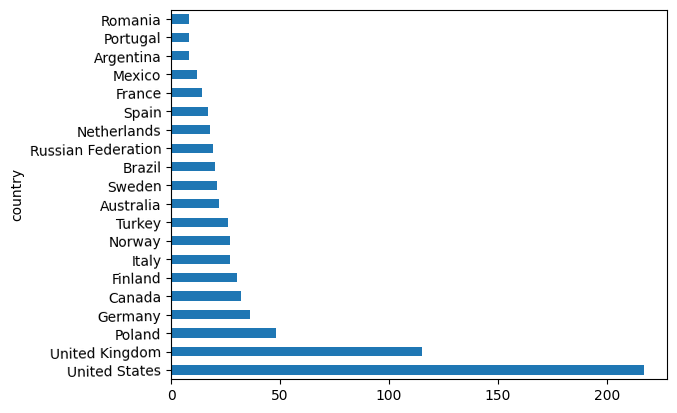

In [9]:
df_users_nonull.country.value_counts().head(20).plot(kind='barh', rot=1)

### Reproducciones

In [10]:
df_plays = pd.read_csv('../data/lastfm/userid-timestamp-artid-artname-traid-traname.tsv', 
                       sep='\t',
                       header=None,
                       on_bad_lines='skip',
                       names=['user_id', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name'])
df_plays.drop(columns=['artist_id', 'track_id'], axis=1, inplace=True)

In [11]:
df_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19098853 entries, 0 to 19098852
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   timestamp    object
 2   artist_name  object
 3   track_name   object
dtypes: object(4)
memory usage: 582.9+ MB


In [12]:
df_plays.dropna(inplace=True)

In [13]:
df_plays.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 19098643 entries, 0 to 19098852
Data columns (total 4 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      object
 1   timestamp    object
 2   artist_name  object
 3   track_name   object
dtypes: object(4)
memory usage: 1.5+ GB


In [14]:
df_plays = df_plays.loc[df_plays['user_id'].isin(df_users_nonull['#id'])]

In [ ]:
df_plays.info()

In [ ]:
df_plays.sample(5)

### Matching entre Spotify y Lastfm datasets

In [15]:
df_spotify = pd.read_csv('../data/spotify-kaggle/raw/dataset.csv', index_col=0)

In [16]:
df_spotify.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   track_id          114000 non-null  object
 1   artists           113999 non-null  object
 2   album_name        113999 non-null  object
 3   track_name        113999 non-null  object
 4   popularity        114000 non-null  int64
 5   duration_ms       114000 non-null  int64
 6   explicit          114000 non-null  bool
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 non-null  float64

In [17]:
df_plays_inters = df_plays.loc[(df_plays['artist_name'] + df_plays['track_name']).isin(df_spotify['artists'] + df_spotify['track_name'])]

In [18]:
df_plays_inters.track_name.nunique()

5968

In [19]:
len(df_plays_inters)

832464

In [20]:
df_plays_inters.user_id.nunique()

840

### Alternativa al matching anterior

In [21]:
import re

def normalize_text(text, is_spotify_format=False):
    if pd.isna(text): 
        return ""
    text = str(text).lower()
    
    # --- PASO CRÍTICO: Manejo de múltiples artistas (Solo para el DF de Spotify) ---
    if is_spotify_format and ';' in text:
        # "Bad Bunny;Jhay Cortez" -> se queda con "Bad Bunny"
        text = text.split(';')[0]
    
    # 1. Eliminar texto entre parentesis o corchetes (Remastered, Live, etc.)
    text = re.sub(r'\s*[\(\[].*?[\)\]]', '', text)
    
    # 2. Eliminar palabras comunes de colaboración (feat, ft, with, &, vs)
    # Esto ayuda si Last.fm tiene "Artist A feat. Artist B"
    text = re.sub(r'\s(feat|ft|with|prod|&|vs)\.?\s.*', '', text)
    
    # 3. Eliminar caracteres no alfanuméricos
    text = re.sub(r'[^\w\s]', '', text)
    
    # 4. Eliminar espacios extra
    return text.strip()

# --- APLICACIÓN ---

# 1. Limpieza Last.fm (Tu dataset df_plays)
# Asumimos que aquí solo hay un artista o texto libre
df_plays['clean_artist'] = df_plays['artist_name'].apply(lambda x: normalize_text(x, is_spotify_format=False))
df_plays['clean_track'] = df_plays['track_name'].apply(lambda x: normalize_text(x))

# 2. Limpieza Spotify (Tu dataset df_spotify)
# Aquí activamos el flag is_spotify_format=True para que rompa los punto y coma
df_spotify['clean_artist'] = df_spotify['artists'].apply(lambda x: normalize_text(x, is_spotify_format=True))
df_spotify['clean_track'] = df_spotify['track_name'].apply(lambda x: normalize_text(x))

# 3. Crear llaves y cruzar
df_plays['join_key'] = df_plays['clean_artist'] + " " + df_plays['clean_track']
df_spotify['join_key'] = df_spotify['clean_artist'] + " " + df_spotify['clean_track']

# Inner Join para ver qué sobrevivió
df_merged = pd.merge(
    df_plays, 
    df_spotify, 
    on='join_key', 
    how='inner'
)

print(f"Canciones únicas tras limpieza mejorada: {df_merged['join_key'].nunique()}")
print(f"Total de interacciones recuperadas: {len(df_merged)}")
print(f"Total usuarios únicos en interacciones: {df_merged['user_id'].nunique()}")

Canciones únicas tras limpieza mejorada: 9963
Total de interacciones recuperadas: 3022852
Total usuarios únicos en interacciones: 840


In [22]:
df_merged.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3022852 entries, 0 to 3022851
Data columns (total 29 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           object
 1   timestamp         object
 2   artist_name       object
 3   track_name_x      object
 4   clean_artist_x    object
 5   clean_track_x     object
 6   join_key          object
 7   track_id          object
 8   artists           object
 9   album_name        object
 10  track_name_y      object
 11  popularity        int64
 12  duration_ms       int64
 13  explicit          bool
 14  danceability      float64
 15  energy            float64
 16  key               int64
 17  loudness          float64
 18  mode              int64
 19  speechiness       float64
 20  acousticness      float64
 21  instrumentalness  float64
 22  liveness          float64
 23  valence           float64
 24  tempo             float64
 25  time_signature    int64
 26  track_genre       object
 27  clean_arti

In [23]:
df_merged.drop(columns=['clean_artist_x', 'clean_track_x', 'track_name_x',
                        'clean_artist_y', 'clean_track_y',
                        'join_key'], inplace=True)

In [24]:
df_merged.drop(columns=['artists'], inplace=True)

In [26]:
df_merged.rename(columns={'track_name_y': 'track_name'}, inplace=True)

,user_id,timestamp,artist_name,track_id,album_name,track_name,popularity,duration_ms,explicit,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,user_000001,2009-04-26T02:40:37Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,False,0.454,...,-7.520,0,0.0395,0.003550,0.906000,0.3340,0.743,78.987,4,trip-hop
1,user_000001,2009-04-18T15:52:50Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,False,0.454,...,-7.520,0,0.0395,0.003550,0.906000,0.3340,0.743,78.987,4,trip-hop
2,user_000001,2009-04-14T13:55:56Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,False,0.454,...,-7.520,0,0.0395,0.003550,0.906000,0.3340,0.743,78.987,4,trip-hop
3,user_000001,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,False,0.866,...,-4.498,0,0.0410,0.000937,0.014500,0.0549,0.644,124.841,4,electronic
4,user_000001,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,False,0.866,...,-4.498,0,0.0410,0.000937,0.014500,0.0549,0.644,124.841,4,french
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022847,user_001000,2008-01-31T21:55:57Z,Radiohead,0YJ9FWWHn9EfnN0lHwbzvV,In Rainbows,Jigsaw Falling Into Place,69,248893,False,0.462,...,-6.085,0,0.0479,0.108000,0.004160,0.0741,0.807,165.653,4,alt-rock
3022848,user_001000,2008-01-31T21:30:06Z,Radiohead,35YyxFpE0ZTOoqFx5bADW8,In Rainbows,Nude,69,255386,False,0.516,...,-9.785,1,0.0342,0.832000,0.579000,0.0857,0.167,128.378,3,alt-rock
3022849,user_001000,2008-01-29T00:40:20Z,Dj Vadim,2hqH6WqU3CkDRT8ftJR4Na,USSR:Life From The Other Side,Viagra,20,178360,False,0.806,...,-7.396,0,0.4820,0.508000,0.000003,0.1070,0.913,88.606,4,trip-hop
3022850,user_001000,2008-01-28T05:24:39Z,M.I.A.,1ixbwbeBi5ufN4noUKmW5a,Kala,Paper Planes,77,205200,False,0.447,...,-6.175,1,0.2220,0.033000,0.000075,0.6500,0.485,172.253,4,indie-pop


In [27]:
df_merged.sample(5)

,user_id,timestamp,artist_name,track_id,album_name,track_name,popularity,duration_ms,explicit,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
896577,user_000294,2006-01-20T12:58:39Z,Arctic Monkeys,6uV5q0yxaOujbxkwUCUEEf,I Bet You Look Good On The Dancefloor,I Bet You Look Good On The Dancefloor,53,176466,False,0.538,...,-3.621,0,0.0358,0.000112,0.000000,0.3340,0.733,103.172,4,garage
1896817,user_000654,2007-09-03T07:45:11Z,The Offspring,4EchqUKQ3qAQuRNKmeIpnf,Americana,The Kids Aren't Alright,81,180160,False,0.523,...,-4.203,1,0.0337,0.007040,0.000038,0.0579,0.766,99.607,4,punk-rock
2232653,user_000751,2007-09-05T09:52:29Z,Metallica,5sICkBXVmaCQk5aISGR3x1,Metallica,Enter Sandman,81,331266,False,0.577,...,-8.691,0,0.0298,0.002130,0.011400,0.0581,0.604,123.257,4,metal
387530,user_000134,2008-05-22T02:13:07Z,The Beatles,6EdSN1iGtLPhcz43QDRkdK,Love,Help!,58,138285,False,0.552,...,-7.126,0,0.0291,0.221000,0.000000,0.1160,0.846,94.887,4,british
1788371,user_000615,2008-12-23T17:22:52Z,Nat King Cole,3nNWzKzHeJ21LwEgmSg9QX,pov: you saw mommy kissing santa claus,The Christmas Song (Merry Christmas To You),0,192373,False,0.525,...,-16.836,1,0.0500,0.994000,0.157000,0.1060,0.170,91.205,3,jazz


In [28]:
# distribucion de reproducciones por usuario
df_merged['user_id'].value_counts().describe()

count      840.000000
mean      3598.633333
std       5803.916801
min          1.000000
25%        545.750000
50%       1709.000000
75%       4347.000000
max      74037.000000
Name: count, dtype: float64

<Axes: >

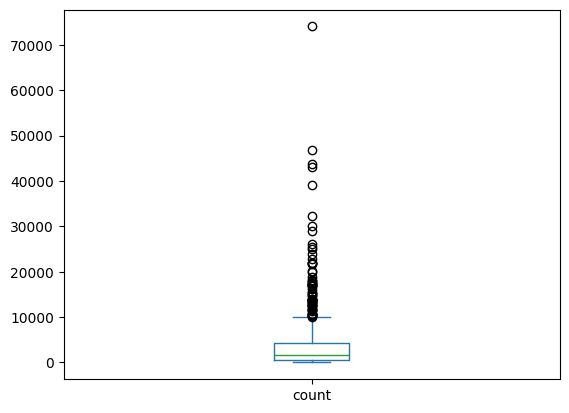

In [29]:
df_merged['user_id'].value_counts().plot(kind='box')

In [30]:
df_merged.to_csv('../data/spotify-kaggle/interim/lastfm_spotify_merged.csv', index=False)

### Unir tambien informacion del usuario

In [32]:
%load_ext cudf.pandas
import pandas as pd

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [33]:
df = pd.read_csv('../data/spotify-kaggle/interim/lastfm_spotify_merged.csv')


In [34]:
df_users = pd.read_csv('../data/lastfm/userid-profile.tsv', sep='\t')

In [35]:
df.head()

,user_id,timestamp,artist_name,track_id,album_name,track_name,popularity,duration_ms,explicit,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,user_000001,2009-04-26T02:40:37Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,False,0.454,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
1,user_000001,2009-04-18T15:52:50Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,False,0.454,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
2,user_000001,2009-04-14T13:55:56Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,False,0.454,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
3,user_000001,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,False,0.866,...,-4.498,0,0.0410,0.000937,0.0145,0.0549,0.644,124.841,4,electronic
4,user_000001,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,False,0.866,...,-4.498,0,0.0410,0.000937,0.0145,0.0549,0.644,124.841,4,french


In [36]:
df_users.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   #id         992 non-null    object
 1   gender      884 non-null    object
 2   age         286 non-null    int64
 3   country     907 non-null    object
 4   registered  984 non-null    object
dtypes: int64(1), object(4)
memory usage: 55.3+ KB


In [37]:
df_users.drop(columns=['age', 'registered'], axis=1, inplace=True)

In [38]:
df_users = df_users.dropna()

In [39]:
df_users.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 848 entries, 0 to 991
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   #id      848 non-null    object
 1   gender   848 non-null    object
 2   country  848 non-null    object
dtypes: object(3)
memory usage: 34.7+ KB


In [40]:
df_merged = pd.merge(
    df_users,
    df,
    right_on='user_id',
    left_on='#id',
    how='inner'
)

In [41]:
df_merged.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3022852 entries, 0 to 3022851
Data columns (total 25 columns):
 #   Column            Dtype
---  ------            -----
 0   #id               object
 1   gender            object
 2   country           object
 3   user_id           object
 4   timestamp         object
 5   artist_name       object
 6   track_id          object
 7   album_name        object
 8   track_name        object
 9   popularity        int64
 10  duration_ms       int64
 11  explicit          bool
 12  danceability      float64
 13  energy            float64
 14  key               int64
 15  loudness          float64
 16  mode              int64
 17  speechiness       float64
 18  acousticness      float64
 19  instrumentalness  float64
 20  liveness          float64
 21  valence           float64
 22  tempo             float64
 23  time_signature    int64
 24  track_genre       object
dtypes: bool(1), float64(9), int64(5), object(10)
memory usage: 810.8+ MB


In [42]:
df_merged.drop(columns=['user_id'], inplace=True)
df_merged.rename(columns={'#id': 'user_id'}, inplace=True)

,user_id,gender,country,timestamp,artist_name,track_id,album_name,track_name,popularity,duration_ms,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,user_000001,m,Japan,2009-04-26T02:40:37Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.906000,0.3340,0.743,78.987,4,trip-hop
1,user_000001,m,Japan,2009-04-18T15:52:50Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.906000,0.3340,0.743,78.987,4,trip-hop
2,user_000001,m,Japan,2009-04-14T13:55:56Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.906000,0.3340,0.743,78.987,4,trip-hop
3,user_000001,m,Japan,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,...,-4.498,0,0.0410,0.000937,0.014500,0.0549,0.644,124.841,4,electronic
4,user_000001,m,Japan,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,...,-4.498,0,0.0410,0.000937,0.014500,0.0549,0.644,124.841,4,french
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022847,user_001000,m,United States,2008-01-31T21:55:57Z,Radiohead,0YJ9FWWHn9EfnN0lHwbzvV,In Rainbows,Jigsaw Falling Into Place,69,248893,...,-6.085,0,0.0479,0.108000,0.004160,0.0741,0.807,165.653,4,alt-rock
3022848,user_001000,m,United States,2008-01-31T21:30:06Z,Radiohead,35YyxFpE0ZTOoqFx5bADW8,In Rainbows,Nude,69,255386,...,-9.785,1,0.0342,0.832000,0.579000,0.0857,0.167,128.378,3,alt-rock
3022849,user_001000,m,United States,2008-01-29T00:40:20Z,Dj Vadim,2hqH6WqU3CkDRT8ftJR4Na,USSR:Life From The Other Side,Viagra,20,178360,...,-7.396,0,0.4820,0.508000,0.000003,0.1070,0.913,88.606,4,trip-hop
3022850,user_001000,m,United States,2008-01-28T05:24:39Z,M.I.A.,1ixbwbeBi5ufN4noUKmW5a,Kala,Paper Planes,77,205200,...,-6.175,1,0.2220,0.033000,0.000075,0.6500,0.485,172.253,4,indie-pop


In [43]:
df_merged.head()

,user_id,gender,country,timestamp,artist_name,track_id,album_name,track_name,popularity,duration_ms,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,user_000001,m,Japan,2009-04-26T02:40:37Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
1,user_000001,m,Japan,2009-04-18T15:52:50Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
2,user_000001,m,Japan,2009-04-14T13:55:56Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
3,user_000001,m,Japan,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,...,-4.498,0,0.0410,0.000937,0.0145,0.0549,0.644,124.841,4,electronic
4,user_000001,m,Japan,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,...,-4.498,0,0.0410,0.000937,0.0145,0.0549,0.644,124.841,4,french


In [46]:
print(f"Total de interacciones finales: {len(df_merged)}")
print(f"Total usuarios únicos finales: {df_merged['user_id'].nunique()}")
print(f"Total canciones únicas finales (nombre artista-track): {(df_merged['artist_name'] + df_merged['track_name']).nunique()}")
print(f"Total canciones únicas finales (track_id): {df_merged['track_id'].nunique()}")

Total de interacciones finales: 3022852
Total usuarios únicos finales: 840
Total canciones únicas finales (nombre artista-track): 10681
Total canciones únicas finales (track_id): 12177


In [49]:
df_merged.to_csv('../data/spotify-kaggle/interim/lastfm_spotify_merged.csv', index=False)

### EDA Sobre nuevo Dataset

In [22]:
%load_ext cudf.pandas
import pandas as pd

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [24]:
df_merged = pd.read_csv('../data/spotify-kaggle/interim/lastfm_spotify_merged.csv')

In [25]:
df_merged.dropna(inplace=True)

In [26]:
#df_merged.to_csv('../data/spotify-kaggle/interim/lastfm_spotify_merged.csv', index=False)

In [27]:
df_merged.head()

,user_id,gender,country,timestamp,artist_name,track_id,album_name,track_name,popularity,duration_ms,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,user_000001,m,Japan,2009-04-26T02:40:37Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
1,user_000001,m,Japan,2009-04-18T15:52:50Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
2,user_000001,m,Japan,2009-04-14T13:55:56Z,Röyksopp,4iVbMHv3CYSF3zVKKoUA18,Junior,Röyksopp Forever,44,299920,...,-7.520,0,0.0395,0.003550,0.9060,0.3340,0.743,78.987,4,trip-hop
3,user_000001,m,Japan,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,...,-4.498,0,0.0410,0.000937,0.0145,0.0549,0.644,124.841,4,electronic
4,user_000001,m,Japan,2009-04-13T15:21:04Z,Miss Kittin & The Hacker,6wptozcE7gLLscFWnhUgxB,Tsugi Electro,Frank Sinatra,2,232417,...,-4.498,0,0.0410,0.000937,0.0145,0.0549,0.644,124.841,4,french


In [28]:
(df_merged['artist_name'] + df_merged['track_name']).nunique()

10681

In [29]:
(df_merged['artist_name'] + df_merged['track_name'] + df_merged['album_name']).nunique()

12780

In [30]:
df_merged['track_id'].nunique()

12176

In [34]:
df_merged.sort_values(by=['artist_name', 'track_name', 'track_id'])

,user_id,gender,country,timestamp,artist_name,track_id,album_name,track_name,popularity,duration_ms,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
2230081,user_000750,m,Italy,2007-08-05T09:33:27Z,(70/80) Boney M.,3WMbD1OyfKuwWDWMNbPQ4g,Take The Heat Off Me,Daddy Cool,72,208600,...,-6.932,0,0.0364,0.28100,0.790000,0.134,0.929,124.431,4,disco
2230082,user_000750,m,Italy,2007-08-05T09:33:27Z,(70/80) Boney M.,702Xo5V8OhlY2cQEczCT2j,Daddy Cool,Daddy Cool,49,206093,...,-12.476,0,0.0381,0.25100,0.640000,0.228,0.959,124.702,4,disco
33222,user_000011,m,Finland,2006-11-12T16:07:04Z,(Həd) P.E.,0lCpIGHKCbzZQpWLkXkzbY,Broke,Bartender,24,240000,...,-5.826,0,0.0582,0.00302,0.000003,0.075,0.414,96.130,4,industrial
33511,user_000011,m,Finland,2006-08-28T21:40:07Z,(Həd) P.E.,0lCpIGHKCbzZQpWLkXkzbY,Broke,Bartender,24,240000,...,-5.826,0,0.0582,0.00302,0.000003,0.075,0.414,96.130,4,industrial
33517,user_000011,m,Finland,2006-08-27T21:18:32Z,(Həd) P.E.,0lCpIGHKCbzZQpWLkXkzbY,Broke,Bartender,24,240000,...,-5.826,0,0.0582,0.00302,0.000003,0.075,0.414,96.130,4,industrial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002723,user_000340,m,Brazil,2009-01-04T08:53:37Z,サザンオールスターズ,0azDpmHy0nK3R6jJabkx0U,SOUTHERN ALL STARS,YOU,43,271666,...,-5.408,0,0.0395,0.05820,0.002680,0.173,0.677,137.784,4,j-pop
1002989,user_000340,m,Brazil,2008-10-22T06:41:29Z,サザンオールスターズ,0azDpmHy0nK3R6jJabkx0U,SOUTHERN ALL STARS,YOU,43,271666,...,-5.408,0,0.0395,0.05820,0.002680,0.173,0.677,137.784,4,j-pop
1003273,user_000340,m,Brazil,2008-08-19T12:21:47Z,サザンオールスターズ,0azDpmHy0nK3R6jJabkx0U,SOUTHERN ALL STARS,YOU,43,271666,...,-5.408,0,0.0395,0.05820,0.002680,0.173,0.677,137.784,4,j-pop
1004022,user_000340,m,Brazil,2007-07-29T10:27:33Z,サザンオールスターズ,0azDpmHy0nK3R6jJabkx0U,SOUTHERN ALL STARS,YOU,43,271666,...,-5.408,0,0.0395,0.05820,0.002680,0.173,0.677,137.784,4,j-pop
